# 주택가격 
## 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

##  데이터 전처리 
### 필요한 라이브러리 가져오기

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

### 데이터 가져오기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(sub_data_path)

print('train_df dim : {}'.format(train_df.shape))
print('test_df dim : {}'.format(test_df.shape))

train_df dim : (15035, 21)
test_df dim : (6468, 20)


In [4]:
train_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [5]:
test_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [6]:
# train_df 정보, 결측치 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
# test_df 정보, 결측치 확인하기
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [8]:
#학습 데이터와 테스터 데이터 연결하기
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [9]:
# train_df, test_dff의 date를 정수형으로 정리
all_df['date'] = all_df['date'].apply(lambda i: i[:8]).astype(int)
all_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,21498,20140626,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,20150126,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,20150219,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,20140623,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [10]:
# id와 index의 번호가 같으므로 'id'삭제
del all_df['id']
all_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,20140626,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,20150126,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,20150219,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,20140623,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


### 범주형, 수치형 데이터 확인하기

In [11]:
# 범주형, 수치형 데이터 확인하기
all_df.date.value_counts()

20140623    142
20140625    131
20140626    131
20140708    127
20150427    126
           ... 
20141102      1
20150131      1
20140830      1
20150308      1
20150215      1
Name: date, Length: 372, dtype: int64

In [12]:
all_df.bedrooms.value_counts()

3     9764
4     6860
2     2746
5     1592
6      271
1      195
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [13]:
all_df.bathrooms.value_counts()

2.50    5364
1.00    3820
1.75    3029
2.25    2034
2.00    1921
1.50    1438
2.75    1183
3.00     750
3.50     729
3.25     586
3.75     155
4.00     135
4.50      99
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [14]:
all_df.sqft_living.value_counts()

1300    136
1400    134
1440    133
1660    128
1800    128
       ... 
3133      1
5210      1
2905      1
2717      1
3118      1
Name: sqft_living, Length: 1038, dtype: int64

In [15]:
all_df.sqft_lot.value_counts()

5000     357
6000     288
4000     250
7200     219
7500     119
        ... 
6086       1
8515       1
12096      1
12786      1
2388       1
Name: sqft_lot, Length: 9782, dtype: int64

In [16]:
all_df.sqft_lot.value_counts()

5000     357
6000     288
4000     250
7200     219
7500     119
        ... 
6086       1
8515       1
12096      1
12786      1
2388       1
Name: sqft_lot, Length: 9782, dtype: int64

In [17]:
all_df.floors.value_counts()

1.0    10612
2.0     8216
1.5     1895
3.0      611
2.5      161
3.5        8
Name: floors, dtype: int64

In [18]:
all_df.waterfront.value_counts()

0    21340
1      163
Name: waterfront, dtype: int64

In [19]:
all_df.view.value_counts()

0    19385
2      962
3      507
1      332
4      317
Name: view, dtype: int64

In [20]:
all_df.condition.value_counts()

3    13961
4     5657
5     1689
2      167
1       29
Name: condition, dtype: int64

In [21]:
all_df.grade.value_counts()

7     8929
8     6050
9     2609
6     2017
10    1131
11     396
5      236
12      89
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

In [22]:
all_df.sqft_above.value_counts()

1300    210
1010    207
1200    204
1220    187
1140    184
       ... 
2659      1
2533      1
4940      1
2905      1
3118      1
Name: sqft_above, Length: 946, dtype: int64

In [23]:
all_df.sqft_basement.value_counts()

0       13056
600       220
700       217
500       212
800       206
        ...  
2580        1
2196        1
415         1
3260        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

In [24]:
all_df.yr_built.value_counts()

2014    558
2006    454
2005    450
2004    431
2003    422
       ... 
1933     29
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [25]:
all_df.yr_renovated.value_counts()

0       20590
2014       91
2013       37
2003       36
2005       35
        ...  
1948        1
1951        1
1944        1
1954        1
1934        1
Name: yr_renovated, Length: 70, dtype: int64

In [26]:
all_df.zipcode.value_counts()

98103    600
98038    587
98115    578
98052    571
98117    550
        ... 
98102    105
98010     99
98024     80
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64

In [27]:
all_df.lat.value_counts()

47.6846    17
47.5491    17
47.5322    17
47.6624    17
47.6711    16
           ..
47.3918     1
47.3916     1
47.4179     1
47.6089     1
47.2815     1
Name: lat, Length: 5034, dtype: int64

In [28]:
all_df.long.value_counts()

-122.290    115
-122.300    110
-122.362    103
-122.291    100
-122.363     99
           ... 
-121.893      1
-121.739      1
-121.737      1
-121.782      1
-121.403      1
Name: long, Length: 752, dtype: int64

In [29]:
all_df.sqft_living15.value_counts()

1540    196
1440    192
1560    191
1500    181
1460    168
       ... 
2256      1
2688      1
2155      1
1282      1
2594      1
Name: sqft_living15, Length: 777, dtype: int64

In [30]:
all_df.sqft_lot15.value_counts()

5000     426
4000     355
6000     289
7200     210
4800     144
        ... 
7064       1
14475      1
43005      1
37026      1
2007       1
Name: sqft_lot15, Length: 8689, dtype: int64

### 범주형 변수 정의

In [31]:
# 범주형 변수를 범주형으로 정의
categories = ['floors', 'waterfront', 'view', 'condition', 'grade']
for i in categories:
    all_df[i] = all_df[i].astype('category')
    
    
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21503 non-null  int64   
 1   price          15035 non-null  float64 
 2   bedrooms       21503 non-null  int64   
 3   bathrooms      21503 non-null  float64 
 4   sqft_living    21503 non-null  int64   
 5   sqft_lot       21503 non-null  int64   
 6   floors         21503 non-null  category
 7   waterfront     21503 non-null  category
 8   view           21503 non-null  category
 9   condition      21503 non-null  category
 10  grade          21503 non-null  category
 11  sqft_above     21503 non-null  int64   
 12  sqft_basement  21503 non-null  int64   
 13  yr_built       21503 non-null  int64   
 14  yr_renovated   21503 non-null  int64   
 15  zipcode        21503 non-null  int64   
 16  lat            21503 non-null  float64 
 17  long           21503 non-null  

### 훈련,  테스트 데이터셋 분리

In [32]:
train_df = all_df[~all_df['price'].isnull()]
test_df = all_df[all_df['price'].isnull()]

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           15035 non-null  int64   
 1   price          15035 non-null  float64 
 2   bedrooms       15035 non-null  int64   
 3   bathrooms      15035 non-null  float64 
 4   sqft_living    15035 non-null  int64   
 5   sqft_lot       15035 non-null  int64   
 6   floors         15035 non-null  category
 7   waterfront     15035 non-null  category
 8   view           15035 non-null  category
 9   condition      15035 non-null  category
 10  grade          15035 non-null  category
 11  sqft_above     15035 non-null  int64   
 12  sqft_basement  15035 non-null  int64   
 13  yr_built       15035 non-null  int64   
 14  yr_renovated   15035 non-null  int64   
 15  zipcode        15035 non-null  int64   
 16  lat            15035 non-null  float64 
 17  long           15035 non-null  

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 15035 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           6468 non-null   int64   
 1   price          0 non-null      float64 
 2   bedrooms       6468 non-null   int64   
 3   bathrooms      6468 non-null   float64 
 4   sqft_living    6468 non-null   int64   
 5   sqft_lot       6468 non-null   int64   
 6   floors         6468 non-null   category
 7   waterfront     6468 non-null   category
 8   view           6468 non-null   category
 9   condition      6468 non-null   category
 10  grade          6468 non-null   category
 11  sqft_above     6468 non-null   int64   
 12  sqft_basement  6468 non-null   int64   
 13  yr_built       6468 non-null   int64   
 14  yr_renovated   6468 non-null   int64   
 15  zipcode        6468 non-null   int64   
 16  lat            6468 non-null   float64 
 17  long           6468 non-null

### 훈련 데이터 수치형 변수 추출, 이상치 제거하기

#### 평균에서 표준편차 3배 이상 또는 3배 이하의 값 추출

In [35]:
num_features = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 
                'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

outlier = []
for col in num_features:
    tmp_df = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * 3) | \
                     (train_df[col] < train_df[col].mean() - train_df[col].std() * 3)]
    
    if len(tmp_df) > 0:
        outlier.append(col)
    
    print(col, len(tmp_df))
    
print("\noutlier :", outlier)

date 0
price 271
bedrooms 43
bathrooms 123
sqft_living 174
sqft_lot 244
sqft_above 173
sqft_basement 168
yr_built 0
yr_renovated 631
zipcode 0
lat 0
long 169
sqft_living15 164
sqft_lot15 254

outlier : ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'long', 'sqft_living15', 'sqft_lot15']


In [36]:
outlier_df = train_df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                       'yr_renovated', 'long', 'sqft_living15', 'sqft_lot15']]
outlier_df

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_renovated,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1180,0,0,-122.257,1340,5650
1,2,1.00,770,10000,770,0,0,-122.233,2720,8062
2,3,2.00,1680,8080,1680,0,0,-122.045,1800,7503
3,3,2.25,1715,6819,1715,0,0,-122.327,2238,6819
4,3,1.50,1060,9711,1060,0,0,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...
15030,4,2.50,2520,6023,2520,0,0,-122.167,2520,6023
15031,4,3.50,3510,7200,2600,910,0,-122.398,2050,6200
15032,3,2.50,1530,1131,1530,0,0,-122.346,1530,1509
15033,4,2.50,2310,5813,2310,0,0,-122.362,1830,7200


### 이상치 그래프로 확인하기

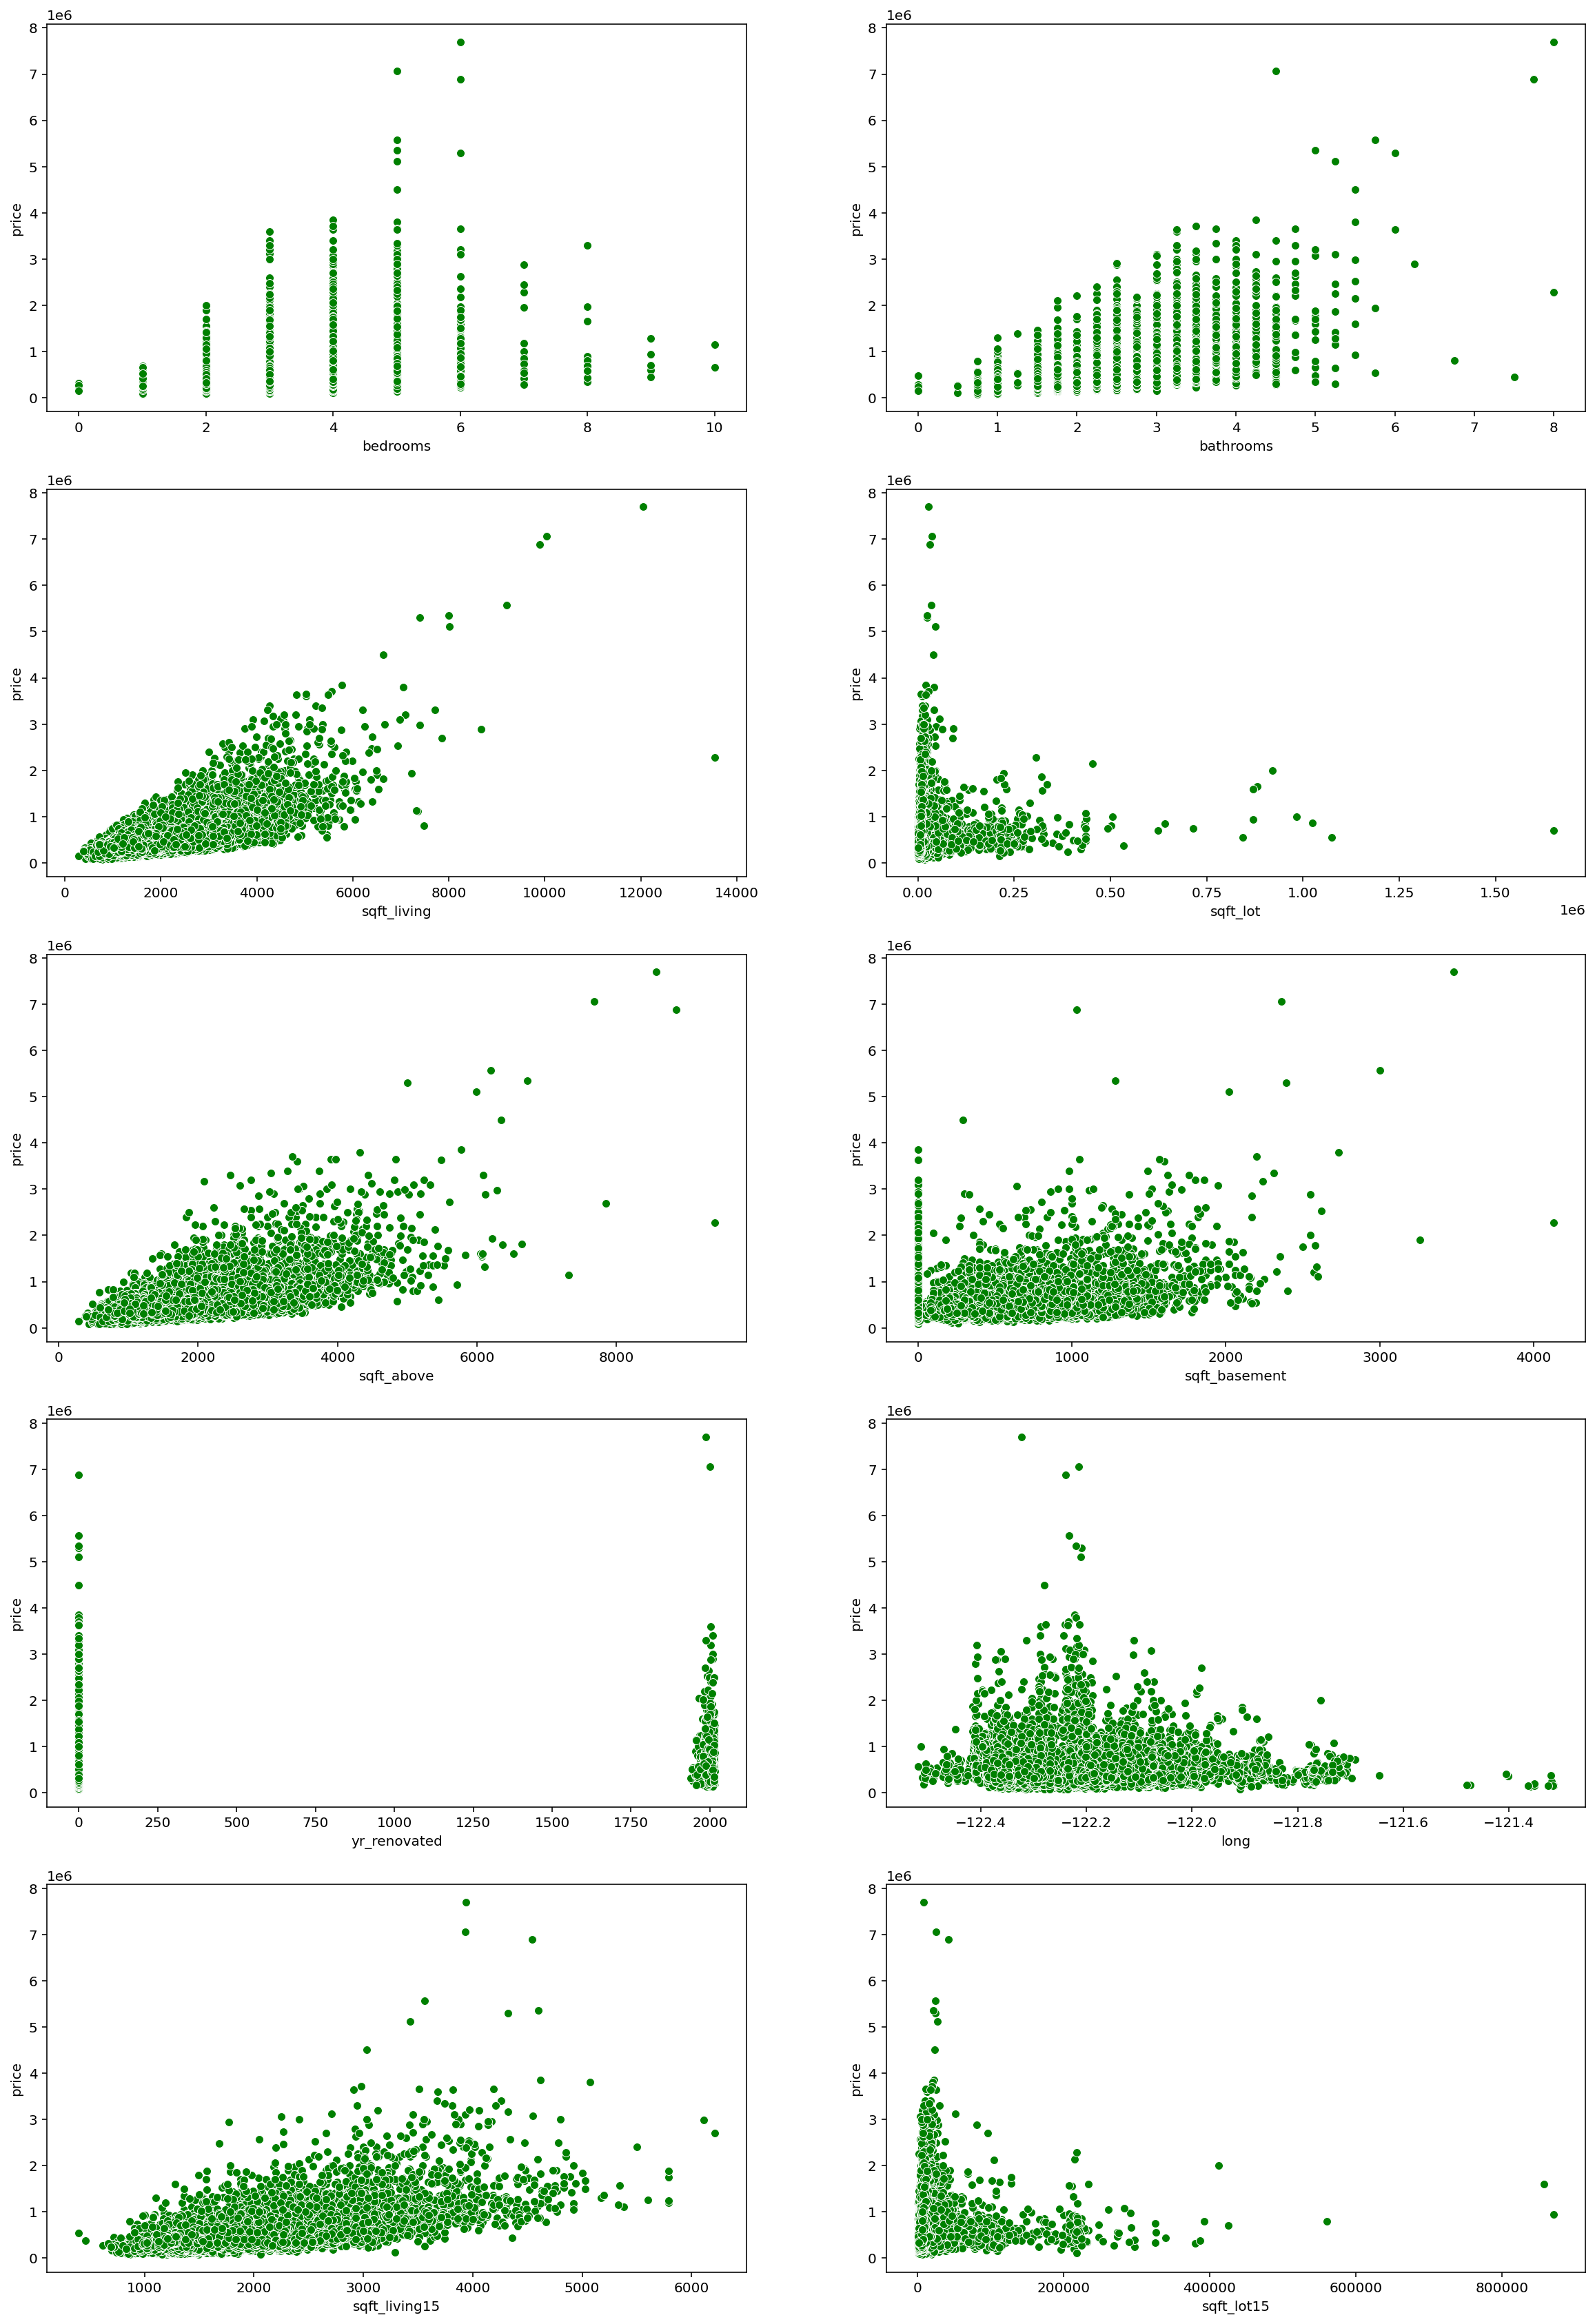

In [37]:
# scatter 그래프 그리기 scatter
fig, ax = plt.subplots(5, 2, figsize=(20, 30))

count = 0
columns = outlier_df.columns
for row in range(5):
    for col in range(2):
        sns.scatterplot(x=outlier_df[columns[count]], y=train_df['price'], ax=ax[row][col], color='green')        
        count+=1
        

### price가 낮은 데 수치가 큰 데이터 찾기

In [38]:
train_df[train_df['sqft_living'] > 13000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,20140505,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [39]:
train_df[train_df['sqft_lot'] > 1500000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1231,20150327,700000.0,4,1.0,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581


In [40]:
train_df[train_df['sqft_above'] > 9000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,20140505,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [41]:
train_df[train_df['sqft_basement'] > 4000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,20140505,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [42]:
train_df[train_df['sqft_living15'] > 6000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7246,20141212,2983000.0,5,5.5,7400,18898,2.0,0,3,3,13,6290,1110,2001,0,98006,47.5431,-122.112,6110,26442
13809,20150122,2700000.0,4,4.0,7850,89651,2.0,0,0,3,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832


In [43]:
train_df[train_df['sqft_lot15'] > 800000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6779,20150107,937500.0,4,4.0,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.676,-121.882,3420,871200
14225,20150415,1600000.0,4,5.5,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.664,-121.878,1280,858132


In [44]:
# 이상치 제거
train_df = train_df.drop(index = [1231, 6779, 7246, 8912, 13809, 14225], axis=0)

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           15029 non-null  int64   
 1   price          15029 non-null  float64 
 2   bedrooms       15029 non-null  int64   
 3   bathrooms      15029 non-null  float64 
 4   sqft_living    15029 non-null  int64   
 5   sqft_lot       15029 non-null  int64   
 6   floors         15029 non-null  category
 7   waterfront     15029 non-null  category
 8   view           15029 non-null  category
 9   condition      15029 non-null  category
 10  grade          15029 non-null  category
 11  sqft_above     15029 non-null  int64   
 12  sqft_basement  15029 non-null  int64   
 13  yr_built       15029 non-null  int64   
 14  yr_renovated   15029 non-null  int64   
 15  zipcode        15029 non-null  int64   
 16  lat            15029 non-null  float64 
 17  long           15029 non-null  

### 교차 검증으로 모델 학습과 예측


In [46]:
# 훈련세트, 정답세트 만들기
train_X = train_df.drop('price', axis=1)
train_Y = train_df['price']

In [47]:
# 교차 검증 분할할 데이터 수 설정하기

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 하이퍼 파라미터 설정하기
lgbm_params = {'objective':'regression', 'random_seed':1234, 'learning_rate': 0.015}

In [48]:
# 평균 제곱 오차 라이브러리 불러오기
from sklearn.metrics import mean_squared_error

### 모델별 예측값 저장하기

#### fold별로 작성한 모델을 model에 저장, rmse의 계산 결과를 rmses에 저장
#### oof(out of fold) - 해당 데이터를 제외한 나머지 데이터를 이용하여 타겟의 예측값을 저장

#### -> 솔직히 무슨 말인지.. 모르겠다... ㅎㅎ 

In [49]:
# fold별 예측값 저장하기
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, 
                          early_stopping_rounds=100, verbose_eval=10,)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 12023, number of used features: 19
[LightGBM] [Info] Start training from score 541077.746070
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 9.3685e+10
[20]	valid_0's l2: 7.51404e+10
[30]	valid_0's l2: 6.1295e+10
[40]	valid_0's l2: 5.07786e+10
[50]	valid_0's l2: 4.25728e+10
[60]	valid_0's l2: 3.63421e+10
[70]	valid_0's l2: 3.15351e+10
[80]	valid_0's l2: 2.77968e+10
[90]	valid_0's l2: 2.50925e+10
[100]	valid_0's l2: 2.30446e+10
[110]	valid_0's l2: 2.15307e+10
[120]	valid_0's l2: 2.03124e+10
[130]	valid_0's l2: 1.94105e+10
[140]	valid_0's l2: 1.87909e+10
[150]	valid_0's l2: 1.82959e+10
[160]	valid_0's l2: 1.78707e+10
[170]	valid_0's l2: 1.74594e+10
[180]	valid_0's l2: 1.71216e+10
[190]	valid_0's l2: 1.6

[400]	valid_0's l2: 1.74458e+10
[410]	valid_0's l2: 1.74067e+10
[420]	valid_0's l2: 1.73743e+10
[430]	valid_0's l2: 1.73452e+10
[440]	valid_0's l2: 1.73195e+10
[450]	valid_0's l2: 1.72873e+10
[460]	valid_0's l2: 1.72642e+10
[470]	valid_0's l2: 1.72437e+10
[480]	valid_0's l2: 1.72223e+10
[490]	valid_0's l2: 1.71683e+10
[500]	valid_0's l2: 1.71497e+10
[510]	valid_0's l2: 1.71041e+10
[520]	valid_0's l2: 1.71008e+10
[530]	valid_0's l2: 1.70844e+10
[540]	valid_0's l2: 1.7074e+10
[550]	valid_0's l2: 1.70781e+10
[560]	valid_0's l2: 1.70987e+10
[570]	valid_0's l2: 1.70806e+10
[580]	valid_0's l2: 1.70853e+10
[590]	valid_0's l2: 1.70664e+10
[600]	valid_0's l2: 1.70412e+10
[610]	valid_0's l2: 1.70365e+10
[620]	valid_0's l2: 1.70406e+10
[630]	valid_0's l2: 1.70346e+10
[640]	valid_0's l2: 1.70103e+10
[650]	valid_0's l2: 1.69825e+10
[660]	valid_0's l2: 1.69648e+10
[670]	valid_0's l2: 1.69333e+10
[680]	valid_0's l2: 1.69049e+10
[690]	valid_0's l2: 1.68897e+10
[700]	valid_0's l2: 1.68792e+10
[710]	val

[820]	valid_0's l2: 1.39402e+10
[830]	valid_0's l2: 1.39314e+10
[840]	valid_0's l2: 1.39276e+10
[850]	valid_0's l2: 1.3914e+10
[860]	valid_0's l2: 1.39028e+10
[870]	valid_0's l2: 1.39014e+10
[880]	valid_0's l2: 1.38853e+10
[890]	valid_0's l2: 1.38847e+10
[900]	valid_0's l2: 1.38775e+10
[910]	valid_0's l2: 1.3872e+10
[920]	valid_0's l2: 1.38522e+10
[930]	valid_0's l2: 1.38422e+10
[940]	valid_0's l2: 1.38282e+10
[950]	valid_0's l2: 1.38143e+10
[960]	valid_0's l2: 1.3798e+10
[970]	valid_0's l2: 1.3787e+10
[980]	valid_0's l2: 1.3778e+10
[990]	valid_0's l2: 1.37733e+10
[1000]	valid_0's l2: 1.37671e+10
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 1.37662e+10
0.1720964697002919


In [50]:
# rmse 평균 구하기
sum(rmses)/len(rmses)

0.16799245690708905

<AxesSubplot:>

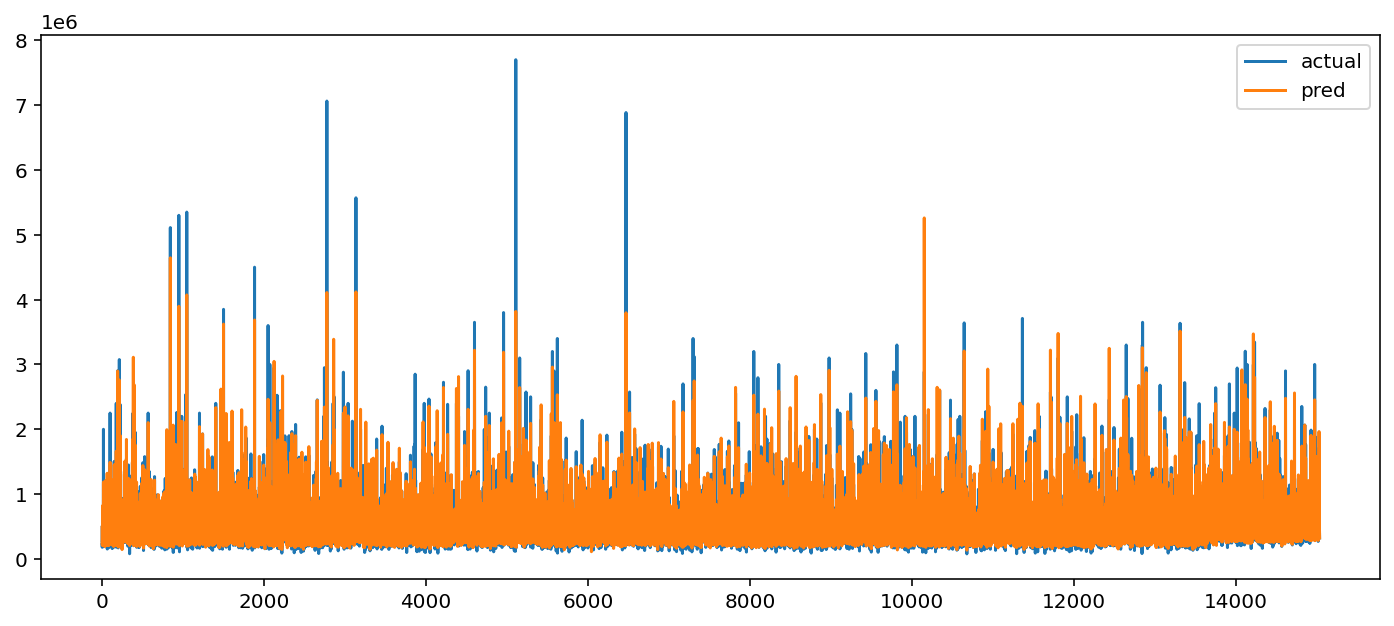

In [51]:
# 현재 예측 값과 실제 값 차이 확인하기

actual_pred_of = pd.DataFrame({'actual' : train_Y, 'pred' : oof})

actual_pred_of.plot(figsize=(12,5))

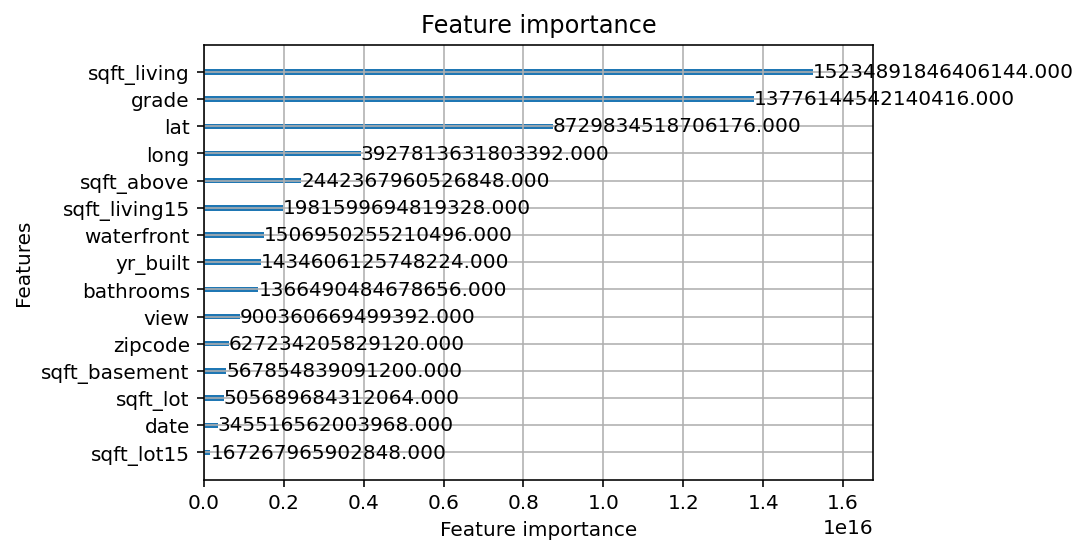

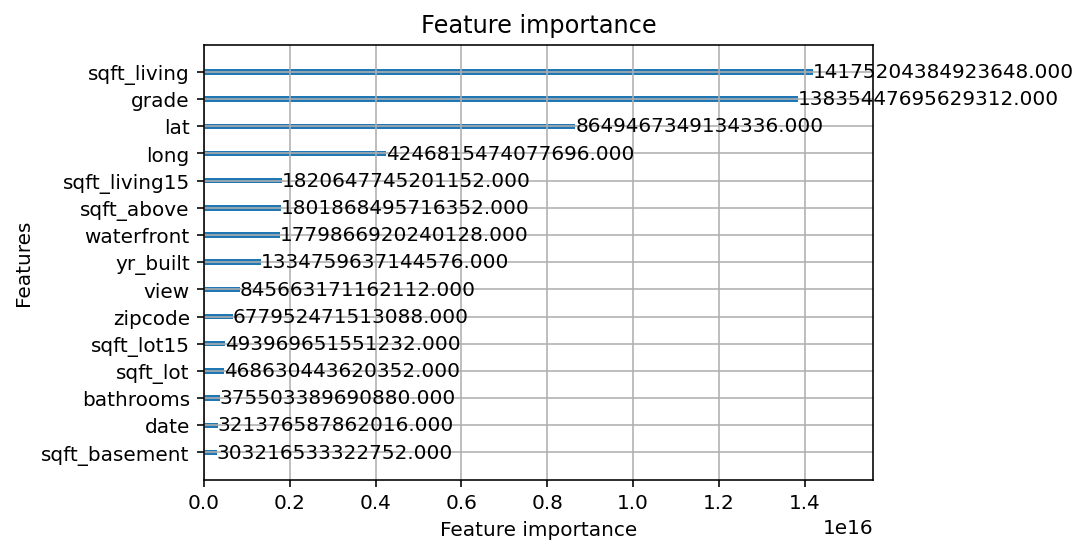

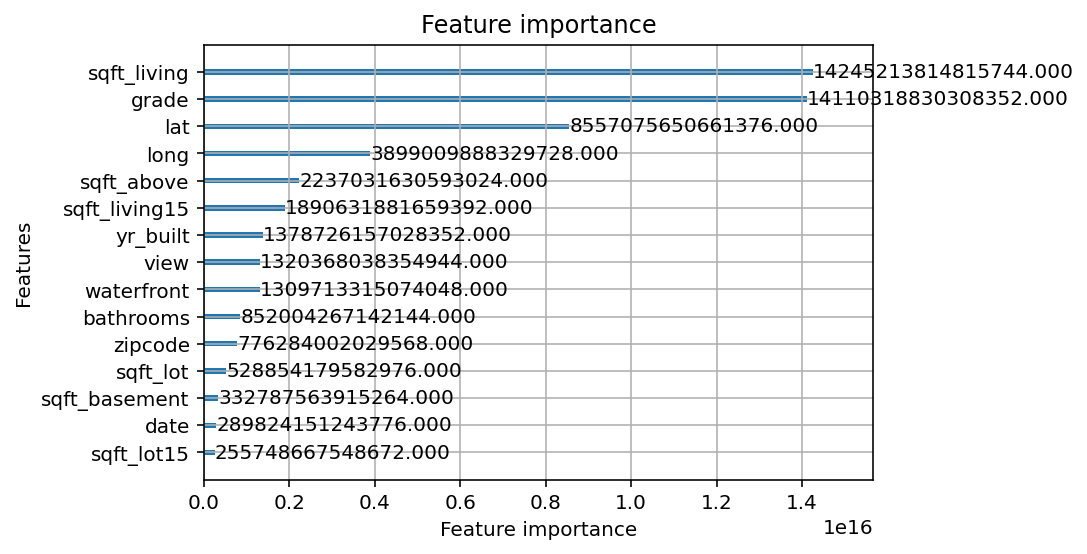

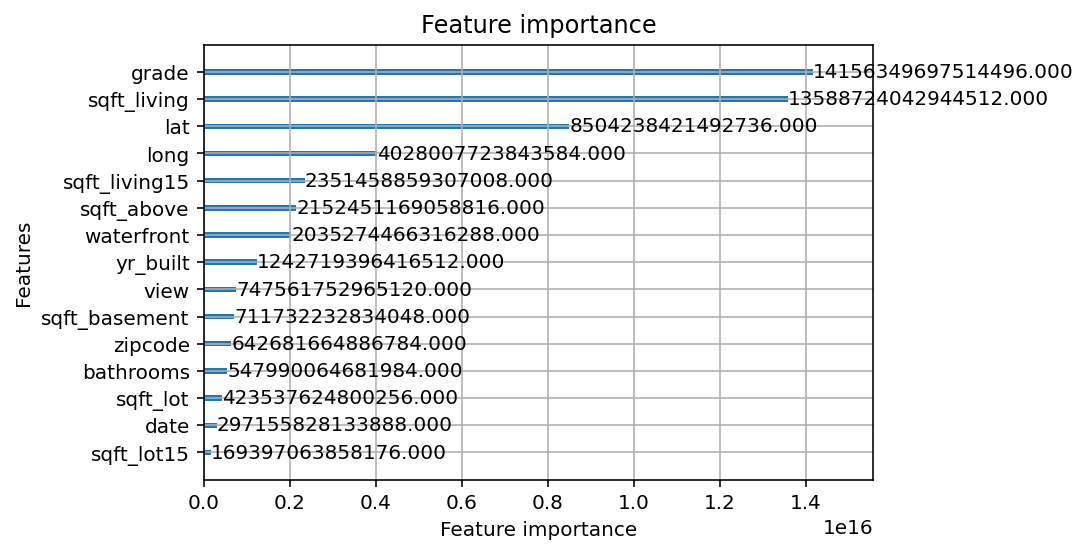

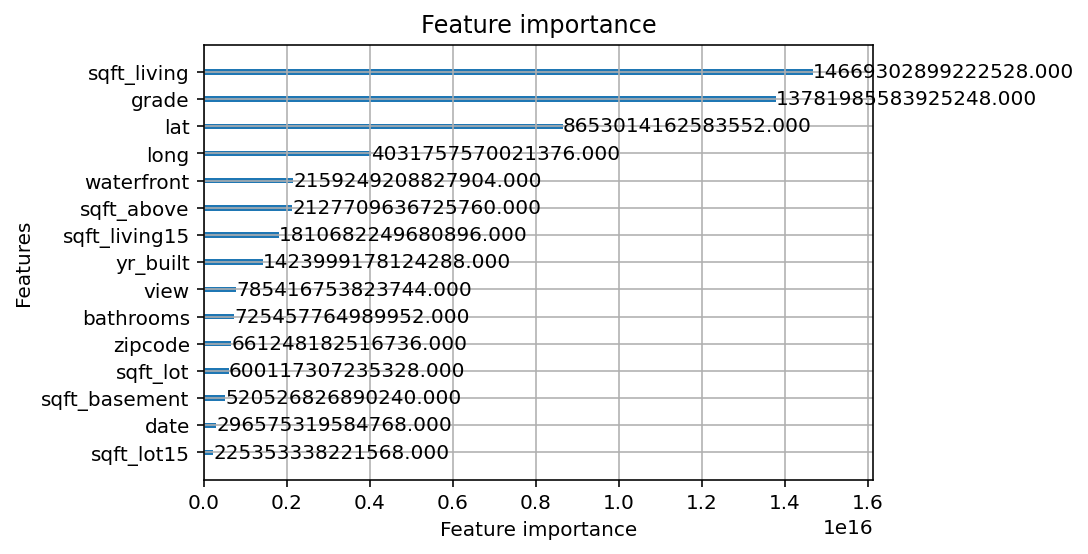

In [52]:
for model in models:
    lgb.plot_importance(model, importance_type='gain', max_num_features=15)

### 정답 분포 확인하기

In [53]:
# price 통계량 확인하기
train_df['price'].describe()

count    1.502900e+04
mean     5.401532e+05
std      3.702568e+05
min      7.800000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

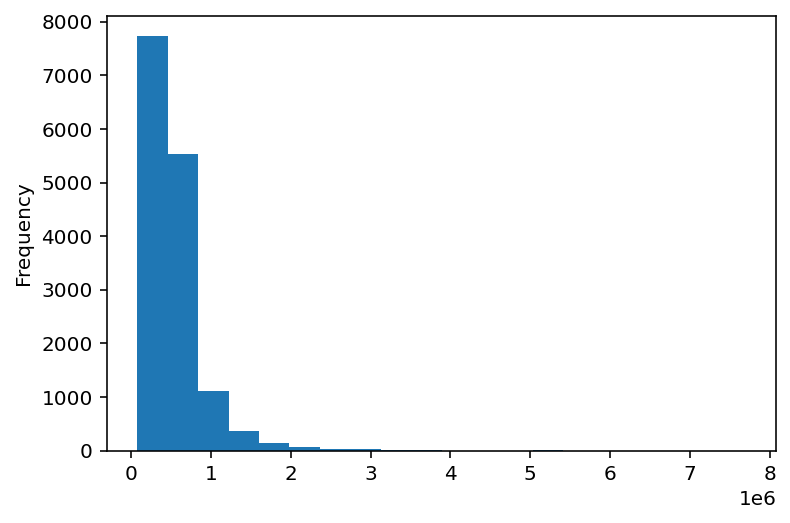

In [54]:
# 히스토그램으로 price분포 확인하기
train_df['price'].plot.hist(bins=20)

In [55]:
# 타겟을 로그화하기
np.log(train_df['price'])

0        12.309982
1        12.100712
2        13.142166
3        12.458775
4        12.583995
           ...    
15030    13.322337
15031    13.822983
15032    12.793859
15033    12.899220
15034    12.691580
Name: price, Length: 15029, dtype: float64

<AxesSubplot:ylabel='Frequency'>

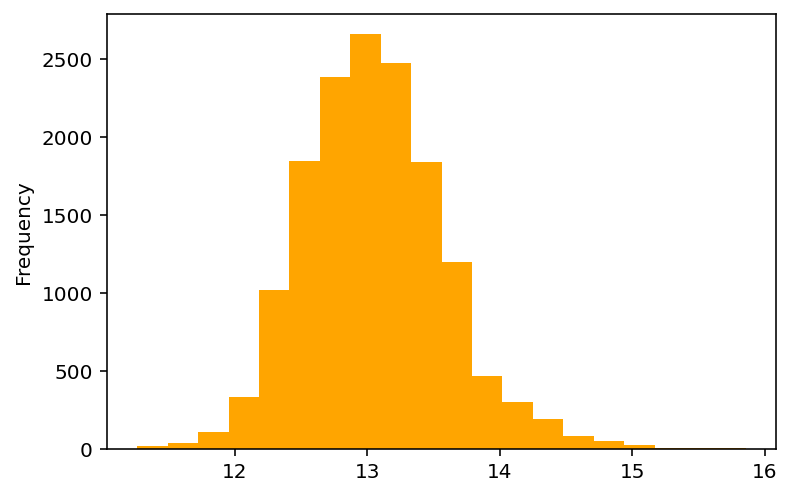

In [56]:
np.log(train_df['price']).plot.hist(bins=20, color='orange')

In [57]:
# 타겟 로그화 하여 예측 정확도 향상시키기
pd.options.mode.chained_assignment = None
train_df['price_log'] = np.log(train_df['price'])

train_X = train_df.drop(['price', 'price_log'], axis=1)
train_Y = train_df['price_log']

In [58]:
# fold별 예측값 저장하기

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, 
                          early_stopping_rounds=100, verbose_eval=10,)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 12023, number of used features: 19
[LightGBM] [Info] Start training from score 13.047444
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 0.212944
[20]	valid_0's l2: 0.172182
[30]	valid_0's l2: 0.140783
[40]	valid_0's l2: 0.116794
[50]	valid_0's l2: 0.0984224
[60]	valid_0's l2: 0.08422
[70]	valid_0's l2: 0.0731194
[80]	valid_0's l2: 0.0643758
[90]	valid_0's l2: 0.0575772
[100]	valid_0's l2: 0.052225
[110]	valid_0's l2: 0.0480075
[120]	valid_0's l2: 0.044572
[130]	valid_0's l2: 0.0417813
[140]	valid_0's l2: 0.0394725
[150]	valid_0's l2: 0.0376038
[160]	valid_0's l2: 0.0359788
[170]	valid_0's l2: 0.0347367
[180]	valid_0's l2: 0.0337542
[190]

[300]	valid_0's l2: 0.0280735
[310]	valid_0's l2: 0.0278556
[320]	valid_0's l2: 0.027664
[330]	valid_0's l2: 0.0274953
[340]	valid_0's l2: 0.0273281
[350]	valid_0's l2: 0.0271927
[360]	valid_0's l2: 0.0270433
[370]	valid_0's l2: 0.0269131
[380]	valid_0's l2: 0.0268208
[390]	valid_0's l2: 0.0267054
[400]	valid_0's l2: 0.02661
[410]	valid_0's l2: 0.0265506
[420]	valid_0's l2: 0.026489
[430]	valid_0's l2: 0.0263987
[440]	valid_0's l2: 0.0263295
[450]	valid_0's l2: 0.0262766
[460]	valid_0's l2: 0.0262357
[470]	valid_0's l2: 0.0261797
[480]	valid_0's l2: 0.0261168
[490]	valid_0's l2: 0.026072
[500]	valid_0's l2: 0.0260272
[510]	valid_0's l2: 0.0259884
[520]	valid_0's l2: 0.0259368
[530]	valid_0's l2: 0.0259048
[540]	valid_0's l2: 0.0258619
[550]	valid_0's l2: 0.0258327
[560]	valid_0's l2: 0.0258016
[570]	valid_0's l2: 0.0257709
[580]	valid_0's l2: 0.0257308
[590]	valid_0's l2: 0.0256987
[600]	valid_0's l2: 0.0256697
[610]	valid_0's l2: 0.0256434
[620]	valid_0's l2: 0.0256084
[630]	valid_0's

[790]	valid_0's l2: 0.028354
[800]	valid_0's l2: 0.0283356
[810]	valid_0's l2: 0.028327
[820]	valid_0's l2: 0.0282982
[830]	valid_0's l2: 0.0282852
[840]	valid_0's l2: 0.0282766
[850]	valid_0's l2: 0.0282642
[860]	valid_0's l2: 0.0282474
[870]	valid_0's l2: 0.0282348
[880]	valid_0's l2: 0.028228
[890]	valid_0's l2: 0.028208
[900]	valid_0's l2: 0.0281697
[910]	valid_0's l2: 0.0281496
[920]	valid_0's l2: 0.0281163
[930]	valid_0's l2: 0.0280992
[940]	valid_0's l2: 0.02807
[950]	valid_0's l2: 0.0280495
[960]	valid_0's l2: 0.0280357
[970]	valid_0's l2: 0.0280201
[980]	valid_0's l2: 0.0280084
[990]	valid_0's l2: 0.0279853
[1000]	valid_0's l2: 0.0279691
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0279691
0.16723958799116126


In [59]:
sum(rmses)/len(rmses)

0.1611767540503815

### 새로운 변수 만들기


In [60]:
# 방의 전체 갯수 
all_df['total_rooms'] = all_df['bedrooms'] + all_df['bathrooms']

# 전용부지 대비 거주공간의 비율 
all_df['sqft_ratio'] = all_df['sqft_living'] / all_df['sqft_lot']

# 재건축 후 전용부지 대비 거주공간의 비율
all_df['sqft_ratio15'] = all_df['sqft_living15'] / all_df['sqft_lot15'] 

# 지하실 유무
all_df['is_basement'] = all_df['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)

# 재건축 여부 
all_df['is_renovated'] = all_df['sqft_living15'] - all_df['sqft_living']
all_df['is_renovated'] = all_df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)


# 지하실, 재건축 범주형 변수로 바꾸기
all_df['is_basement'] = all_df['is_basement'].astype('category')
all_df['is_renovated'] = all_df['is_renovated'].astype('category')

In [61]:
# date를 str로 바꾸기
all_df['date'] = all_df['date'].astype(str)

# date에서 판매한 해를 추출
all_df['yr_solid'] = all_df['date'].apply(lambda i: i[:4]).astype(int)

# date int로 원상복구
all_df['date'] = all_df['date'].astype(int)

all_df['age'] = all_df['yr_solid'] - all_df['yr_built']

all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21503 non-null  int64   
 1   price          15035 non-null  float64 
 2   bedrooms       21503 non-null  int64   
 3   bathrooms      21503 non-null  float64 
 4   sqft_living    21503 non-null  int64   
 5   sqft_lot       21503 non-null  int64   
 6   floors         21503 non-null  category
 7   waterfront     21503 non-null  category
 8   view           21503 non-null  category
 9   condition      21503 non-null  category
 10  grade          21503 non-null  category
 11  sqft_above     21503 non-null  int64   
 12  sqft_basement  21503 non-null  int64   
 13  yr_built       21503 non-null  int64   
 14  yr_renovated   21503 non-null  int64   
 15  zipcode        21503 non-null  int64   
 16  lat            21503 non-null  float64 
 17  long           21503 non-null  

In [62]:
# 훈련, 테스트 세트 분리하기
train_df = all_df[~all_df['price'].isnull()]
test_df = all_df[all_df['price'].isnull()]

# 타겟 로그화 하여 예측 정확도 향상시키기
pd.options.mode.chained_assignment = None
train_df['price_log'] = np.log(train_df['price'])

# 학습, 정답라벨 만들기
train_X = train_df.drop(['price', 'price_log'], axis=1)
train_Y = train_df['price_log']

In [63]:
# fold별 예측값 저장하기

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, 
                          early_stopping_rounds=100, verbose_eval=10,)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.047361
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 0.222495
[20]	valid_0's l2: 0.180641
[30]	valid_0's l2: 0.148781
[40]	valid_0's l2: 0.123934
[50]	valid_0's l2: 0.104776
[60]	valid_0's l2: 0.09
[70]	valid_0's l2: 0.0784669
[80]	valid_0's l2: 0.0694308
[90]	valid_0's l2: 0.0623174
[100]	valid_0's l2: 0.0566134
[110]	valid_0's l2: 0.0521142
[120]	valid_0's l2: 0.0485067
[130]	valid_0's l2: 0.0455877
[140]	valid_0's l2: 0.0432038
[150]	valid_0's l2: 0.0412333
[160]	valid_0's l2: 0.0395622
[170]	valid_0's l2: 0.0382525
[180]	valid_0's l2: 0.0371439
[190]	valid_0's l2: 0.0362096
[200]	valid_0's l2: 0.035437
[210]	valid_

[290]	valid_0's l2: 0.0281081
[300]	valid_0's l2: 0.0278452
[310]	valid_0's l2: 0.0276322
[320]	valid_0's l2: 0.0274183
[330]	valid_0's l2: 0.0271997
[340]	valid_0's l2: 0.027
[350]	valid_0's l2: 0.0268246
[360]	valid_0's l2: 0.0266481
[370]	valid_0's l2: 0.0265045
[380]	valid_0's l2: 0.0263881
[390]	valid_0's l2: 0.0262584
[400]	valid_0's l2: 0.0261521
[410]	valid_0's l2: 0.0260386
[420]	valid_0's l2: 0.025952
[430]	valid_0's l2: 0.0258606
[440]	valid_0's l2: 0.0257724
[450]	valid_0's l2: 0.0256896
[460]	valid_0's l2: 0.0256144
[470]	valid_0's l2: 0.0255333
[480]	valid_0's l2: 0.0254702
[490]	valid_0's l2: 0.0254045
[500]	valid_0's l2: 0.0253282
[510]	valid_0's l2: 0.0252764
[520]	valid_0's l2: 0.0252226
[530]	valid_0's l2: 0.0251648
[540]	valid_0's l2: 0.0251148
[550]	valid_0's l2: 0.0250922
[560]	valid_0's l2: 0.0250585
[570]	valid_0's l2: 0.0250444
[580]	valid_0's l2: 0.0250016
[590]	valid_0's l2: 0.0249756
[600]	valid_0's l2: 0.024938
[610]	valid_0's l2: 0.0249147
[620]	valid_0's 

KeyboardInterrupt: 

In [ ]:
sum(rmses)/len(rmses)

## 최적의 하이퍼파라미터 찾기
### Optuna이용하기

In [ ]:
#! pip install optuna==2.0.0

### 학습, 검증 데이터 만들기

In [64]:
import optuna
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_X, train_Y, test_size=0.2,
                                                     random_state=42, shuffle=False, stratify=None)

In [66]:
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,
        'n_estimators':1000,
        'num_leaves':trial.suggest_int('max_leaves', 4, 64),
        'max_bin':trial.suggest_int('max_bin', 50, 200),
        'bagging_fraction':trial.suggest_uniform('bagging_fraction', 0.4, 0.9),
        'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':trial.suggest_uniform('feature_fraction', 0.4, 0.9),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 2, 16),
        'min_sum_hessian_in_leaf':trial.suggest_int('min_sum_hessian_in_leaf', 1, 10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         num_boost_round=100,
                         early_stopping_rounds=20,
                         verbose_eval=10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [67]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2022-01-25 08:26:05,479] Trial 0 finished with value: 0.5277950224888772 and parameters: {'max_leaves': 48, 'max_bin': 97, 'bagging_fraction': 0.7575946831862097, 'bagging_freq': 4, 'feature_fraction': 0.8289728088113784, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.5277950224888772.
[I 2022-01-25 08:26:05,576] Trial 1 finished with value: 0.5280022410746027 and parameters: {'max_leaves': 23, 'max_bin': 71, 'bagging_fraction': 0.5921908536463499, 'bagging_freq': 8, 'feature_fraction': 0.8458865003910399, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.5277950224888772.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1497
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279243
[20]	valid_0's l2: 0.279838
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279401
[20]	valid_0's l2: 0.279951
Early stoppi

[I 2022-01-25 08:26:05,686] Trial 2 finished with value: 0.5279259305003744 and parameters: {'max_leaves': 42, 'max_bin': 89, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 9, 'feature_fraction': 0.5963923980504149, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.5277950224888772.
[I 2022-01-25 08:26:05,783] Trial 3 finished with value: 0.5276016440990431 and parameters: {'max_leaves': 13, 'max_bin': 198, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 4, 'feature_fraction': 0.8785775794765232, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.2793
[20]	valid_0's l2: 0.279956
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278774
[20]	valid_0's l2: 0.279399
Early stopping, best iteration is:
[5]	valid_0's l2: 0.278363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in th

[I 2022-01-25 08:26:05,890] Trial 4 finished with value: 0.5278340631880034 and parameters: {'max_leaves': 39, 'max_bin': 79, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 8, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:05,994] Trial 5 finished with value: 0.5278416979809863 and parameters: {'max_leaves': 36, 'max_bin': 81, 'bagging_fraction': 0.4529538035938961, 'bagging_freq': 8, 'feature_fraction': 0.5322778060523135, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279002
[20]	valid_0's l2: 0.279208
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278609
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278933
[20]	valid_0's l2: 0.279767
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278617


[I 2022-01-25 08:26:06,113] Trial 6 finished with value: 0.527957189640643 and parameters: {'max_leaves': 59, 'max_bin': 78, 'bagging_fraction': 0.6842169744343243, 'bagging_freq': 1, 'feature_fraction': 0.5620705038966071, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:06,218] Trial 7 finished with value: 0.5279445359617961 and parameters: {'max_leaves': 44, 'max_bin': 67, 'bagging_fraction': 0.8718740392573121, 'bagging_freq': 10, 'feature_fraction': 0.6249749949556138, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279519
[20]	valid_0's l2: 0.279948
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278739
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279331
[20]	valid_0's l2: 0.28008
Early stoppin

[I 2022-01-25 08:26:06,301] Trial 8 finished with value: 0.5278726425306045 and parameters: {'max_leaves': 5, 'max_bin': 107, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 8, 'feature_fraction': 0.4854547925680226, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:06,397] Trial 9 finished with value: 0.527826326848095 and parameters: {'max_leaves': 18, 'max_bin': 149, 'bagging_fraction': 0.5818553854713113, 'bagging_freq': 10, 'feature_fraction': 0.4192127132363674, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278849
[20]	valid_0's l2: 0.278938
Early stopping, best iteration is:
[1]	valid_0's l2: 0.27865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	

[I 2022-01-25 08:26:06,490] Trial 10 finished with value: 0.5279494686211204 and parameters: {'max_leaves': 10, 'max_bin': 97, 'bagging_fraction': 0.5044383780474173, 'bagging_freq': 4, 'feature_fraction': 0.8976497838389439, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:06,588] Trial 11 finished with value: 0.527969191547293 and parameters: {'max_leaves': 18, 'max_bin': 193, 'bagging_fraction': 0.6373487511442064, 'bagging_freq': 8, 'feature_fraction': 0.5690038074194459, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 3 with value: 0.5276016440990431.



[20]	valid_0's l2: 0.279372
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2588
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279242
[20]	valid_0's l2: 0.279643
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278751
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't

[I 2022-01-25 08:26:06,707] Trial 12 finished with value: 0.527978274789966 and parameters: {'max_leaves': 52, 'max_bin': 99, 'bagging_fraction': 0.7891727410129545, 'bagging_freq': 4, 'feature_fraction': 0.5843625853304821, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:06,827] Trial 13 finished with value: 0.5276323885214221 and parameters: {'max_leaves': 53, 'max_bin': 86, 'bagging_fraction': 0.44804920394698156, 'bagging_freq': 4, 'feature_fraction': 0.6343256008238508, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.5276016440990431.


[20]	valid_0's l2: 0.280348
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278761
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278646
[20]	valid_0's l2: 0.279551
Early stopping, best iteration is:
[4]	valid_0's l2: 0.278396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125


[I 2022-01-25 08:26:06,984] Trial 14 finished with value: 0.5279188187822612 and parameters: {'max_leaves': 43, 'max_bin': 199, 'bagging_fraction': 0.7696317896991509, 'bagging_freq': 1, 'feature_fraction': 0.6208554606244228, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 3 with value: 0.5276016440990431.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279416
[20]	valid_0's l2: 0.280275
Early stopping, best iteration is:
[4]	valid_0's l2: 0.278698
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279738
[20]	valid_0's l2: 0.280622


[I 2022-01-25 08:26:07,116] Trial 15 finished with value: 0.5279404591446477 and parameters: {'max_leaves': 63, 'max_bin': 180, 'bagging_fraction': 0.7443305914028853, 'bagging_freq': 4, 'feature_fraction': 0.8591177331810724, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:07,273] Trial 16 finished with value: 0.5277916935611139 and parameters: {'max_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.5326947454697227, 'bagging_freq': 10, 'feature_fraction': 0.8605788051185999, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 3 with value: 0.5276016440990431.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.278721
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278706
[20]	valid_0's l2: 0.280004
Early stopping, best iteration is:
[6]	valid_0's l2: 0.278564
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26


[I 2022-01-25 08:26:07,392] Trial 17 finished with value: 0.5277124833555621 and parameters: {'max_leaves': 47, 'max_bin': 154, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 4, 'feature_fraction': 0.7235870700937778, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:07,500] Trial 18 finished with value: 0.5277029460713836 and parameters: {'max_leaves': 42, 'max_bin': 69, 'bagging_fraction': 0.5989103763793145, 'bagging_freq': 4, 'feature_fraction': 0.4100537730937468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279001
[20]	valid_0's l2: 0.27971
Early stopping, best iteration is:
[1]	valid_0's l2: 0.27848
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1130
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279016
[20]	valid_0's l2: 0.279762
Early stopping, best iteration is:
[3]	valid_0's l2: 0.27847


[I 2022-01-25 08:26:07,583] Trial 19 finished with value: 0.5278813759200642 and parameters: {'max_leaves': 6, 'max_bin': 53, 'bagging_fraction': 0.7518686396449581, 'bagging_freq': 1, 'feature_fraction': 0.5243765717599791, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:07,691] Trial 20 finished with value: 0.5278705780020989 and parameters: {'max_leaves': 30, 'max_bin': 117, 'bagging_fraction': 0.8763745057584925, 'bagging_freq': 1, 'feature_fraction': 0.8232043362355639, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.27885
[20]	valid_0's l2: 0.278904
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1763
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279137
[20]	valid_0's l2: 0.279583
Early stopping

[I 2022-01-25 08:26:07,788] Trial 21 finished with value: 0.5278083463184929 and parameters: {'max_leaves': 17, 'max_bin': 171, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.5248981378274891, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:07,902] Trial 22 finished with value: 0.5278918224211239 and parameters: {'max_leaves': 50, 'max_bin': 75, 'bagging_fraction': 0.6942325425343747, 'bagging_freq': 10, 'feature_fraction': 0.6506621909633512, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 3 with value: 0.5276016440990431.



Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278876
[20]	valid_0's l2: 0.279402
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279068
[20]	valid_0's l2: 0.280363
Early stopping, best iteration is:
[3]	valid_0's l2: 0.27867


[I 2022-01-25 08:26:08,016] Trial 23 finished with value: 0.5278269353747342 and parameters: {'max_leaves': 37, 'max_bin': 154, 'bagging_fraction': 0.6119275242790898, 'bagging_freq': 10, 'feature_fraction': 0.6350660946278825, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 3 with value: 0.5276016440990431.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279058
[20]	valid_0's l2: 0.279698
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278601
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]

[I 2022-01-25 08:26:08,142] Trial 24 finished with value: 0.5280985943734547 and parameters: {'max_leaves': 60, 'max_bin': 129, 'bagging_fraction': 0.7745849185763624, 'bagging_freq': 9, 'feature_fraction': 0.46773703211122514, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:08,287] Trial 25 finished with value: 0.5278640962302236 and parameters: {'max_leaves': 51, 'max_bin': 143, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 7, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 3 with value: 0.5276016440990431.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.278888
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279114
[20]	valid_0's l2: 0.280571
Early stopping, best iteration is:
[2]	valid_0's l2: 0.27864
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	val

[I 2022-01-25 08:26:08,384] Trial 26 finished with value: 0.5278755189840613 and parameters: {'max_leaves': 7, 'max_bin': 53, 'bagging_fraction': 0.5837809350239482, 'bagging_freq': 7, 'feature_fraction': 0.8920211206820732, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 3 with value: 0.5276016440990431.
[I 2022-01-25 08:26:08,495] Trial 27 finished with value: 0.5278223548259217 and parameters: {'max_leaves': 27, 'max_bin': 93, 'bagging_fraction': 0.4501134436561506, 'bagging_freq': 9, 'feature_fraction': 0.5761558306002665, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 3 with value: 0.5276016440990431.


[20]	valid_0's l2: 0.279022
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279142
[20]	valid_0's l2: 0.279532
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278596
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start train

[I 2022-01-25 08:26:08,606] Trial 28 finished with value: 0.5275086690419731 and parameters: {'max_leaves': 32, 'max_bin': 161, 'bagging_fraction': 0.41877969191407016, 'bagging_freq': 4, 'feature_fraction': 0.48342375652424985, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:08,727] Trial 29 finished with value: 0.5278674999176495 and parameters: {'max_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.6056983618777273, 'bagging_freq': 4, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.279025
[20]	valid_0's l2: 0.279556
Early stopping, best iteration is:
[4]	valid_0's l2: 0.278265
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279672
[20]	valid_0's l2: 0.280218
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278644


[I 2022-01-25 08:26:08,872] Trial 30 finished with value: 0.5279613004347821 and parameters: {'max_leaves': 45, 'max_bin': 181, 'bagging_fraction': 0.6100376848953053, 'bagging_freq': 3, 'feature_fraction': 0.8331911629643146, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 28 with value: 0.5275086690419731.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279811
[20]	valid_0's l2: 0.281247
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278743
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279062
[20]	valid_0's l2: 0.279521


[I 2022-01-25 08:26:08,996] Trial 31 finished with value: 0.5276679484359796 and parameters: {'max_leaves': 43, 'max_bin': 111, 'bagging_fraction': 0.7649952812120291, 'bagging_freq': 3, 'feature_fraction': 0.6605183031020647, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:09,106] Trial 32 finished with value: 0.5280783297643656 and parameters: {'max_leaves': 44, 'max_bin': 86, 'bagging_fraction': 0.48549329934156576, 'bagging_freq': 3, 'feature_fraction': 0.5119623440301901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 28 with value: 0.5275086690419731.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.278433
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279416
[20]	valid_0's l2: 0.280304
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Tra

[I 2022-01-25 08:26:09,202] Trial 33 finished with value: 0.527821639017087 and parameters: {'max_leaves': 12, 'max_bin': 179, 'bagging_fraction': 0.7918221226509443, 'bagging_freq': 4, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:09,312] Trial 34 finished with value: 0.5278692247832819 and parameters: {'max_leaves': 40, 'max_bin': 75, 'bagging_fraction': 0.5336312689407392, 'bagging_freq': 4, 'feature_fraction': 0.8321407213431223, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 28 with value: 0.5275086690419731.


[20]	valid_0's l2: 0.279658
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278596
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279265
[20]	valid_0's l2: 0.280216
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278646
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start train

[I 2022-01-25 08:26:09,433] Trial 35 finished with value: 0.5277839415784569 and parameters: {'max_leaves': 37, 'max_bin': 196, 'bagging_fraction': 0.6771212175422201, 'bagging_freq': 5, 'feature_fraction': 0.5049218744875611, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:09,528] Trial 36 finished with value: 0.5279198785893423 and parameters: {'max_leaves': 16, 'max_bin': 94, 'bagging_fraction': 0.7697753975246437, 'bagging_freq': 3, 'feature_fraction': 0.8851183415480504, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.278925
[20]	valid_0's l2: 0.279214
Early stopping, best iteration is:
[3]	valid_0's l2: 0.278556
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1459
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279083
[20]	valid_0's l2: 0.279228
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278699
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2664
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training un

[I 2022-01-25 08:26:09,643] Trial 37 finished with value: 0.5278219923846883 and parameters: {'max_leaves': 43, 'max_bin': 200, 'bagging_fraction': 0.6172083127790604, 'bagging_freq': 7, 'feature_fraction': 0.8405022811008375, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:09,799] Trial 38 finished with value: 0.5278004136736013 and parameters: {'max_leaves': 53, 'max_bin': 91, 'bagging_fraction': 0.41233936419566564, 'bagging_freq': 6, 'feature_fraction': 0.771917272654894, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.279347
[20]	valid_0's l2: 0.280668
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278596
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278637
[20]	valid_0's l2: 0.280507
Early stopping, best iteration is:
[8]	valid_0's l2: 0.278573


[I 2022-01-25 08:26:09,922] Trial 39 finished with value: 0.5279906736991394 and parameters: {'max_leaves': 31, 'max_bin': 123, 'bagging_fraction': 0.7035225305582258, 'bagging_freq': 2, 'feature_fraction': 0.8951694736983522, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:10,025] Trial 40 finished with value: 0.52777775785045 and parameters: {'max_leaves': 20, 'max_bin': 156, 'bagging_fraction': 0.4686102100485973, 'bagging_freq': 9, 'feature_fraction': 0.7791893269180707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 28 with value: 0.5275086690419731.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.27975
[20]	valid_0's l2: 0.280778
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278774
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.27872
[20]	valid_0's l2: 0.279074
Early stopping

[I 2022-01-25 08:26:10,117] Trial 41 finished with value: 0.5277804156254865 and parameters: {'max_leaves': 12, 'max_bin': 141, 'bagging_fraction': 0.5623414860332328, 'bagging_freq': 8, 'feature_fraction': 0.4000276784325043, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:10,215] Trial 42 finished with value: 0.5279227777325993 and parameters: {'max_leaves': 27, 'max_bin': 63, 'bagging_fraction': 0.8426688298047929, 'bagging_freq': 9, 'feature_fraction': 0.8763958284859723, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 28 with value: 0.5275086690419731.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278863
[20]	valid_0's l2: 0.279601
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279351
[20]	valid_0's l2: 0.280029
Early stoppi

[I 2022-01-25 08:26:10,319] Trial 43 finished with value: 0.5278739111130939 and parameters: {'max_leaves': 29, 'max_bin': 82, 'bagging_fraction': 0.7654279033850789, 'bagging_freq': 7, 'feature_fraction': 0.5568461962540149, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:10,424] Trial 44 finished with value: 0.5279642934150187 and parameters: {'max_leaves': 26, 'max_bin': 172, 'bagging_fraction': 0.5037350377205547, 'bagging_freq': 9, 'feature_fraction': 0.7652210882833972, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.279517
[20]	valid_0's l2: 0.279617
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279318
[20]	valid_0's l2: 0.280182
Early stopping, best iteration is:
[2]	valid_0's l2: 0.278746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[

[I 2022-01-25 08:26:10,521] Trial 45 finished with value: 0.5278733261376725 and parameters: {'max_leaves': 12, 'max_bin': 189, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 5, 'feature_fraction': 0.4874544371547538, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:10,629] Trial 46 finished with value: 0.5279139327566297 and parameters: {'max_leaves': 39, 'max_bin': 155, 'bagging_fraction': 0.8202142662677163, 'bagging_freq': 3, 'feature_fraction': 0.47242387967168864, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.278888
[20]	valid_0's l2: 0.279222
Early stopping, best iteration is:
[2]	valid_0's l2: 0.27865
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279069
[20]	valid_0's l2: 0.279687
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278693
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[L

[I 2022-01-25 08:26:10,790] Trial 47 finished with value: 0.527734774409753 and parameters: {'max_leaves': 64, 'max_bin': 68, 'bagging_fraction': 0.7734971200997518, 'bagging_freq': 2, 'feature_fraction': 0.8518598698729667, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 28 with value: 0.5275086690419731.
[I 2022-01-25 08:26:10,902] Trial 48 finished with value: 0.5278485937535909 and parameters: {'max_leaves': 34, 'max_bin': 109, 'bagging_fraction': 0.6922380344778845, 'bagging_freq': 4, 'feature_fraction': 0.5460737633962744, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 28 with value: 0.5275086690419731.


[10]	valid_0's l2: 0.27909
[20]	valid_0's l2: 0.280198
Early stopping, best iteration is:
[5]	valid_0's l2: 0.278504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.279302
[20]	valid_0's l2: 0.280074
Early stopping, best iteration is:
[1]	valid_0's l2: 0.278624


[I 2022-01-25 08:26:11,015] Trial 49 finished with value: 0.5273575199074495 and parameters: {'max_leaves': 48, 'max_bin': 63, 'bagging_fraction': 0.4082148147957371, 'bagging_freq': 7, 'feature_fraction': 0.4046200367432704, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 49 with value: 0.5273575199074495.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.048125
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.278459
[20]	valid_0's l2: 0.279611
Early stopping, best iteration is:
[6]	valid_0's l2: 0.278106


{'max_leaves': 48,
 'max_bin': 63,
 'bagging_fraction': 0.4082148147957371,
 'bagging_freq': 7,
 'feature_fraction': 0.4046200367432704,
 'min_data_in_leaf': 15,
 'min_sum_hessian_in_leaf': 9}

In [68]:
lgbm_params = {
    'objective':'regression',
    'random_seed':1234,
    'learning_rate':0.05,
    'n_estimators':1000,
    'max_leaves': 13,
    'max_bin': 198,
    'bagging_fraction': 0.4101091987201629,
    'bagging_freq': 4,
    'feature_fraction': 0.8785775794765232,
    'min_data_in_leaf': 2,
    'min_sum_hessian_in_leaf': 3    
}

In [69]:
# 훈련, 테스트 세트 분리하기
train_df = all_df[~all_df['price'].isnull()]
test_df = all_df[all_df['price'].isnull()]

# 타겟 로그화 하여 예측 정확도 향상시키기
train_df['price_log'] = np.log(train_df['price'])

# 학습, 정답라벨 만들기
train_X = train_df.drop(['price', 'price_log'], axis=1)
train_Y = train_df['price_log']

In [71]:
# fold별 예측값 저장하기

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, 
                          early_stopping_rounds=100, verbose_eval=10,)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred    
    

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 26
[LightGBM] [Info] Start training from score 13.047361
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 0.147253
[20]	valid_0's l2: 0.091489
[30]	valid_0's l2: 0.0661328
[40]	valid_0's l2: 0.053109
[50]	valid_0's l2: 0.0460146
[60]	valid_0's l2: 0.041762
[70]	valid_0's l2: 0.0383925
[80]	valid_0's l2: 0.0364823
[90]	valid_0's l2: 0.0354817
[100]	valid_0's l2: 0.0346288
[110]	valid_0's l2: 0.0340673
[120]	valid_0's l2: 0.0333111
[130]	valid_0's l2: 0.0327974
[140]	valid_0's l2: 0.0323417
[150]	valid_0's l2: 0.0320479
[160]	valid_0's l2: 0.03185
[170]	valid_0's l2: 0.0313248
[180]	valid_0's l2: 0.0311117
[190]	valid_0's l2: 0.0308742
[200]	valid_0's l2: 0.0305927
[210]	v

[600]	valid_0's l2: 0.0249114
[610]	valid_0's l2: 0.0248696
[620]	valid_0's l2: 0.0248161
[630]	valid_0's l2: 0.0248401
[640]	valid_0's l2: 0.0248586
[650]	valid_0's l2: 0.0248602
[660]	valid_0's l2: 0.0248893
[670]	valid_0's l2: 0.0248536
[680]	valid_0's l2: 0.0248858
[690]	valid_0's l2: 0.0248346
[700]	valid_0's l2: 0.0248304
[710]	valid_0's l2: 0.024852
[720]	valid_0's l2: 0.0248162
[730]	valid_0's l2: 0.0248482
[740]	valid_0's l2: 0.0248079
[750]	valid_0's l2: 0.0248196
[760]	valid_0's l2: 0.0248112
[770]	valid_0's l2: 0.0248049
[780]	valid_0's l2: 0.0248185
[790]	valid_0's l2: 0.0248076
[800]	valid_0's l2: 0.0247446
[810]	valid_0's l2: 0.0246937
[820]	valid_0's l2: 0.0247255
[830]	valid_0's l2: 0.0247143
[840]	valid_0's l2: 0.0246892
[850]	valid_0's l2: 0.0246132
[860]	valid_0's l2: 0.0245901
[870]	valid_0's l2: 0.0245985
[880]	valid_0's l2: 0.0245962
[890]	valid_0's l2: 0.0246035
[900]	valid_0's l2: 0.0245468
[910]	valid_0's l2: 0.0245607
[920]	valid_0's l2: 0.0245629
[930]	valid

In [72]:
sum(rmses)/len(rmses)

0.1637227829175747

### 테스트 결과보기

In [73]:
test_X = test_df.drop(['price'], axis=1)

preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
    
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

preds_exp = np.exp(preds_mean)
len(preds_exp)

6468

In [74]:
# sample_submission.csv 파일을 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

# 훈련한 prediction을 price에 덮어쓰기
submission['price'] = preds_exp
submission.head()

,id,price
0,15035,5.349566e+05
1,15036,4.442696e+05
2,15037,1.355694e+06
3,15038,3.060633e+05
4,15039,3.213347e+05


In [75]:
# 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리
submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, 'LGB7', '0.163722')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGB7_RMSE_0.163722.csv


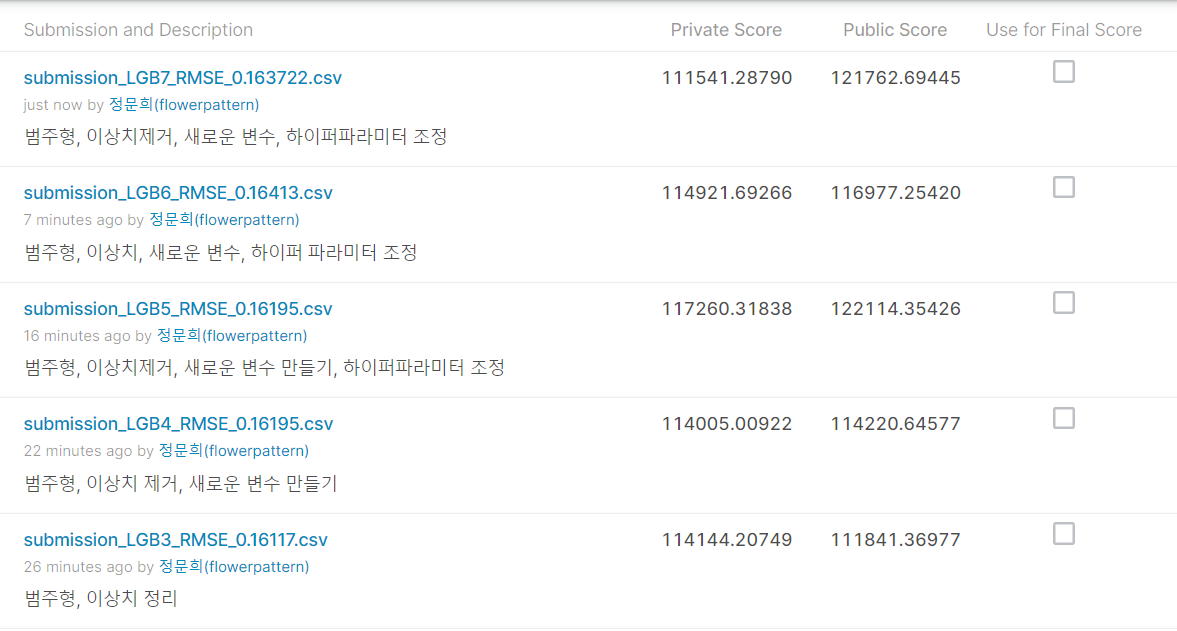

## 회고

### 이번 프로젝트에서 어려웠던 점
#### 1) 변수에 로그를 취해서 점수를 계산하고 다시 어떻게 원상복귀 시키지??
#### 2) 아~~ 귀찮겠군.. 그래서 중요한 변수, price의 상관관계 파악하기
#### 3) 그리고 로그를 하지 말고 정규분포를 해야겠다.
#### 4) 정규분포를 쓰려면 이상치를 제거해야 좋다고 해서 이제는 이상치를 제거하자.
#### 5) 이상치를 제거하고 정규분포를 해서 차수를 뻥튀기해서 다항 회귀를 하고 릿지규제가 좋다고 하니 써보자..
#### 6) 이렇게 주말 하루를 보냈다.. 그리고 결과는 이상하게... ㅎㅎㅎ
#### 7) 데이터 분석을 못하니 도서관에 가서 책을 빌려오자.. 도서관에 캐클에 대한 책이 있네~~ 오~~ 예!!
#### 8) 그리고 준서님이 추천해 준 방식 + 성돈님이 추천해 준 코드.. + 도서관 책
#### 9) 너무 심하게 가져오면 이상할 것 같아서.. 더 고민을 많이 했네요..
#### 10) 중간에 모델설정, optuna는 책에서.. 그리고 추천받은 코드에서 필요한 것을...

### 프로젝트를 진행하면서 알아낸 점 
#### 1) 범주형 데이터를 어떻게 찾고 어떻게 처리하는 지 이해하게 됨
#### 2) DataFrame이 조금은 편해짐
#### 3) 캐글 대회는 평가기준이 있으니.. 마음대로 하지 말고 평가기준을 꼭 명심하자!!
#### 4) 데이터 분석에 대한 고민을 좀 많이 한 것 같고, 모델링에 대해서도 많이 고민했던 것 같아요~
#### 5) LGB모델은 훈련하면 특성 중요도를 알 수 있다.

### 프로젝트를 진행하면서 아직 모호한 점
#### 1) 상관도를 그렸을 때 상관관계가 없는 데이터는 어떻게 해석해야 하나??
#### 2) 이상치의 기준은 어떻게 해야 데이터의 손상이 없이 자료로 쓸 수 있을까??
#### 3) accuracy, predict, score 이건 어디에 어떻게 써야 잘 쓰는 것일까??

### 루브릭 평가 지표를 맞추기 위해 **시도한 것들**
#### 1) 이상치를 제거하는 함수를 가지고 이상치 제거도 하고 정규분포를 이용해서 linearRegerssion와 릿지규제를 사용해 봤음.
#### 2) 중요한 특성 찾는 방법에 대한 연구 , (ex) corr, boxlpot, 정규화.. 등) 데이터분석에 대한 전반적인 흐름을 파악하기
#### 3) 범주형, 새로운 변수 만들기

### 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**
#### 1)모델을 만들었던 코드를 정확히 이해하지 못했다.
#### 2) 책의 도움, 다른 이의 코드의 도움을 받았음에도 불구하고 루브릭 평가 관련 지표를 넘지 못했다.. 하지만 데이터에 대한 전반적인 시각과 어떻게 접근해야 하는 지에 대한 어렴풋한 배움과 DataFrame를 좀 더 편하게 접근할 수 있게 되어서.. 저는 좋아요~~ !!

### 자기다짐
#### 시간 조절을 잘하자!! 그리고 고집을 조금 버리자... ㅎㅎㅎ

### [도움받았던 코드](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)
